In [18]:
#conda env : py36_zBatchAI
import os
import datetime
import imageio
import skimage
import scipy 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from glob import glob
from IPython.display import Image
import h5py

import argparse


In [ ]:
argparse.ArgumentParser

In [15]:
root='C:/Users/zecharpy/Desktop/pix2pix'
dataset_name = 'RetinaData'
import glob
path=glob.glob('%s/%s/%s/*' % (root,dataset_name, 'train'))

batch_images = np.random.choice(path, size=1)
print(batch_images[0])
import cv2
im=cv2.imread(batch_images[0])
im1=scipy.misc.imresize(im,(128,128))

im2=cv2.resize(im,(128,128))
print(im.shape, im1.shape, im2.shape)

C:/Users/zecharpy/Desktop/pix2pix/RetinaData/train\37.jpg
(128, 256, 3) (128, 128, 3) (128, 128, 3)


c:\users\zecharpy\appdata\local\continuum\anaconda3\envs\py36_zbatchai\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.


In [2]:
class DataLoader():
    def __init__(self,root, dataset_name, img_res=(128, 128)):
        self.root=root
        self.dataset_name = dataset_name
        self.img_res = img_res

    def load_data(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "test"
        path = glob('%s/%s/%s/*' % (self.root, self.dataset_name, data_type))
        #print("load_data path", path)
        batch_images = np.random.choice(path, size=batch_size)

        imgs_A = []
        imgs_B = []
        for img_path in batch_images:
            img = self.imread(img_path)

            h, w, _ = img.shape
            _w = int(w/2)
            img_A, img_B = img[:, :_w, :], img[:, _w:, :]

            img_A = cv2.resize(img_A, self.img_res)
            img_B = cv2.resize(img_B, self.img_res)

            # If training => do random flip
            if not is_testing and np.random.random() < 0.5:
                img_A = np.fliplr(img_A)
                img_B = np.fliplr(img_B)

            imgs_A.append(img_A)
            imgs_B.append(img_B)

        imgs_A = np.array(imgs_A)/127.5 - 1.
        imgs_B = np.array(imgs_B)/127.5 - 1.

        return imgs_A, imgs_B

    def load_batch(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "val"
        path =  glob('%s/%s/%s/*' % (self.root, self.dataset_name, data_type))
        #print("load_batch path", path)
        self.n_batches = int(len(path) / batch_size)

        for i in range(self.n_batches-1):
            batch = path[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img in batch:
                img = self.imread(img)
                h, w, _ = img.shape
                half_w = int(w/2)
                img_A = img[:, :half_w, :]
                img_B = img[:, half_w:, :]

                img_A = cv2.resize(img_A, self.img_res)
                img_B = cv2.resize(img_B, self.img_res)

                if not is_testing and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)

            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield imgs_A, imgs_B


    def imread(self, path):
        return imageio.imread(path).astype(np.float)

In [26]:
from __future__ import print_function, division
import scipy
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model, load_model
from keras.models import model_from_json
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import h5py
import sys
import numpy as np
import os

class Pix2Pix():
    def __init__(self):
        # Input shape
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # Configure data loader
        self.root='C:/Users/zecharpy/Desktop/pix2pix'
        self.dataset_name = 'RetinaData'
        self.data_loader = DataLoader(root=self.root ,dataset_name=self.dataset_name,
                                      img_res=(self.img_rows, self.img_cols))


        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = 64
        self.df = 64

        optimizer = Adam(0.0002, 0.5)
        
        if load_exist_models:
            # load json and create model
            json_file = open('keras_epoch100_D_weights.json', 'r')
            loaded_model_json = json_file.read()
            json_file.close()

            # load weights into new model
            
            self.discriminator = model_from_json(loaded_model_json)
            self.discriminator.load_weights('keras_epoch100_D_weights.h5')
            print("Loaded discriminator model from disk")
        # Build and compile the discriminator
        else :
            self.discriminator = self.build_discriminator()
            
        self.discriminator.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generator
        #-------------------------

        # Build the generator
        self.generator = self.build_generator()

        # Input images and their conditioning images
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # By conditioning on B generate a fake version of A
        fake_A = self.generator(img_B)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # Discriminators determines validity of translated images / condition pairs
        valid = self.discriminator([fake_A, img_B])
        
        if load_exist_models:
            # load json and create model
            json_file_2 = open('keras_epoch100_combinedDG_weights.json', 'r')
            loaded_model2_json = json_file_2.read()
            json_file.close()
            loaded_model2 = model_from_json(loaded_model2_json)
            # load weights into new model
            loaded_model2.load_weights("keras_epoch100_combinedDG_weights.h5")
            print("Loaded combined model from disk")

        self.combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
        self.combined.compile(loss=['mse', 'mae'],
                              loss_weights=[1, 100],
                              optimizer=optimizer)

    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4, bn=True):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = BatchNormalization(momentum=0.8)(u)
            u = Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = Input(shape=self.img_shape)

        # Downsampling
        d1 = conv2d(d0, self.gf, bn=False)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*8)
        d5 = conv2d(d4, self.gf*8)
        d6 = conv2d(d5, self.gf*8)
        d7 = conv2d(d6, self.gf*8)

        # Upsampling
        u1 = deconv2d(d7, d6, self.gf*8)
        u2 = deconv2d(u1, d5, self.gf*8)
        u3 = deconv2d(u2, d4, self.gf*8)
        u4 = deconv2d(u3, d3, self.gf*4)
        u5 = deconv2d(u4, d2, self.gf*2)
        u6 = deconv2d(u5, d1, self.gf)

        u7 = UpSampling2D(size=2)(u6)
        output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

        return Model(d0, output_img)

    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, bn=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # Concatenate image and conditioning image by channels to produce input
        combined_imgs = Concatenate(axis=-1)([img_A, img_B])

        d1 = d_layer(combined_imgs, self.df, bn=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model([img_A, img_B], validity)

    def train(self, epochs, batch_size=1, sample_interval=50):

        #start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)
       

        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Condition on B and generate a translated version
                fake_A = self.generator.predict(imgs_B)

                # Train the discriminators (original images = real / generated = Fake)
                d_loss_real = self.discriminator.train_on_batch([imgs_A, imgs_B], valid)
                d_loss_fake = self.discriminator.train_on_batch([fake_A, imgs_B], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # -----------------
                #  Train Generator
                # -----------------

                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])

                #elapsed_time = datetime.datetime.now() - start_time
                # Plot the progress
                print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %f]" % (epoch, epochs,
                                                                        batch_i, self.data_loader.n_batches,
                                                                        d_loss[0], 100*d_loss[1],
                                                                        g_loss[0]))

                # If at save interval => save generated image samples
                if batch_i % sample_interval == 0:
                    self.sample_images(epoch, batch_i)
                    
            model1_json = self.discriminator.to_json()
            with open("keras_D_weights.json", "w") as json_file:
                json_file.write(model1_json)
            self.discriminator.save_weights('keras_D_weights.h5')
            model2_json = self.combined.to_json()
            with open("keras_combinedDG_weights.json", "w") as json_file:
                json_file.write(model2_json)
            self.combined.save_weights('keras_combinedDG_weights.h5')
            

    def sample_images(self, epoch, batch_i):
        os.makedirs('images/%s' % self.dataset_name, exist_ok=True)
        r, c = 3, 3

        imgs_A, imgs_B = self.data_loader.load_data(batch_size=3, is_testing=False)
        fake_A = self.generator.predict(imgs_B)

        gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Condition', 'Generated', 'Original']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[i])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%s/%d_%d.png" % (self.dataset_name, epoch, batch_i))
        plt.close()


In [19]:
# build the pix2pix model
load_exist_models=True
gan = Pix2Pix()
gan.train(epochs=50, batch_size=1, sample_interval=200)

Loaded discriminator model from disk
Loaded combined model from disk


c:\users\zecharpy\appdata\local\continuum\anaconda3\envs\py36_zbatchai\lib\site-packages\keras\engine\training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


[Epoch 0/50] [Batch 0/40] [D loss: 2.921371, acc:  56%] [G loss: 74.639175]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 0/50] [Batch 1/40] [D loss: 0.928270, acc:  38%] [G loss: 58.397530]
[Epoch 0/50] [Batch 2/40] [D loss: 0.443939, acc:  53%] [G loss: 58.937332]
[Epoch 0/50] [Batch 3/40] [D loss: 0.284609, acc:  61%] [G loss: 45.636768]
[Epoch 0/50] [Batch 4/40] [D loss: 0.220875, acc:  71%] [G loss: 49.096783]
[Epoch 0/50] [Batch 5/40] [D loss: 0.216485, acc:  75%] [G loss: 55.371090]
[Epoch 0/50] [Batch 6/40] [D loss: 0.246479, acc:  67%] [G loss: 42.289173]
[Epoch 0/50] [Batch 7/40] [D loss: 0.279849, acc:  67%] [G loss: 43.920662]
[Epoch 0/50] [Batch 8/40] [D loss: 0.269804, acc:  67%] [G loss: 42.306324]
[Epoch 0/50] [Batch 9/40] [D loss: 0.284486, acc:  62%] [G loss: 43.529324]
[Epoch 0/50] [Batch 10/40] [D loss: 0.292310, acc:  66%] [G loss: 32.790237]
[Epoch 0/50] [Batch 11/40] [D loss: 0.128103, acc:  82%] [G loss: 36.734329]
[Epoch 0/50] [Batch 12/40] [D loss: 0.341176, acc:  63%] [G loss: 29.032999]
[Epoch 0/50] [Batch 13/40] [D loss: 0.457446, acc:  54%] [G loss: 32.148754]
[Epoch 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 1/50] [Batch 1/40] [D loss: 0.068624, acc:  95%] [G loss: 17.186195]
[Epoch 1/50] [Batch 2/40] [D loss: 0.177395, acc:  80%] [G loss: 20.897055]
[Epoch 1/50] [Batch 3/40] [D loss: 0.236366, acc:  66%] [G loss: 16.570795]
[Epoch 1/50] [Batch 4/40] [D loss: 0.165685, acc:  75%] [G loss: 20.341656]
[Epoch 1/50] [Batch 5/40] [D loss: 0.241785, acc:  75%] [G loss: 28.755428]
[Epoch 1/50] [Batch 6/40] [D loss: 0.319226, acc:  65%] [G loss: 19.605570]
[Epoch 1/50] [Batch 7/40] [D loss: 0.092290, acc:  91%] [G loss: 22.105347]
[Epoch 1/50] [Batch 8/40] [D loss: 0.049942, acc:  96%] [G loss: 17.198650]
[Epoch 1/50] [Batch 9/40] [D loss: 0.080555, acc:  92%] [G loss: 23.894476]
[Epoch 1/50] [Batch 10/40] [D loss: 0.096689, acc:  88%] [G loss: 21.467709]
[Epoch 1/50] [Batch 11/40] [D loss: 0.074559, acc:  92%] [G loss: 18.687126]
[Epoch 1/50] [Batch 12/40] [D loss: 0.066738, acc:  92%] [G loss: 17.315636]
[Epoch 1/50] [Batch 13/40] [D loss: 0.072772, acc:  91%] [G loss: 21.564432]
[Epoch 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 2/50] [Batch 1/40] [D loss: 0.078532, acc:  91%] [G loss: 16.395611]
[Epoch 2/50] [Batch 2/40] [D loss: 0.125657, acc:  83%] [G loss: 20.343739]
[Epoch 2/50] [Batch 3/40] [D loss: 0.123638, acc:  78%] [G loss: 15.459927]
[Epoch 2/50] [Batch 4/40] [D loss: 0.191208, acc:  77%] [G loss: 18.659885]
[Epoch 2/50] [Batch 5/40] [D loss: 0.249871, acc:  69%] [G loss: 25.635345]
[Epoch 2/50] [Batch 6/40] [D loss: 0.142197, acc:  80%] [G loss: 18.918556]
[Epoch 2/50] [Batch 7/40] [D loss: 0.097591, acc:  91%] [G loss: 19.585390]
[Epoch 2/50] [Batch 8/40] [D loss: 0.099855, acc:  87%] [G loss: 15.303915]
[Epoch 2/50] [Batch 9/40] [D loss: 0.076383, acc:  96%] [G loss: 20.396456]
[Epoch 2/50] [Batch 10/40] [D loss: 0.057383, acc:  92%] [G loss: 22.289192]
[Epoch 2/50] [Batch 11/40] [D loss: 0.058086, acc:  94%] [G loss: 19.508207]
[Epoch 2/50] [Batch 12/40] [D loss: 0.047494, acc:  99%] [G loss: 15.311981]
[Epoch 2/50] [Batch 13/40] [D loss: 0.049158, acc:  97%] [G loss: 18.905251]
[Epoch 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 3/50] [Batch 1/40] [D loss: 0.020412, acc: 100%] [G loss: 14.245654]
[Epoch 3/50] [Batch 2/40] [D loss: 0.090160, acc:  92%] [G loss: 18.141033]
[Epoch 3/50] [Batch 3/40] [D loss: 0.058935, acc:  96%] [G loss: 14.783173]
[Epoch 3/50] [Batch 4/40] [D loss: 0.036591, acc:  98%] [G loss: 17.049349]
[Epoch 3/50] [Batch 5/40] [D loss: 0.040243, acc:  97%] [G loss: 27.943140]
[Epoch 3/50] [Batch 6/40] [D loss: 0.027524, acc:  97%] [G loss: 16.384312]
[Epoch 3/50] [Batch 7/40] [D loss: 0.022559, acc: 100%] [G loss: 17.394209]
[Epoch 3/50] [Batch 8/40] [D loss: 0.030059, acc: 100%] [G loss: 15.323722]
[Epoch 3/50] [Batch 9/40] [D loss: 0.076484, acc:  92%] [G loss: 20.725452]
[Epoch 3/50] [Batch 10/40] [D loss: 0.040294, acc:  97%] [G loss: 19.308947]
[Epoch 3/50] [Batch 11/40] [D loss: 0.102324, acc:  86%] [G loss: 16.414032]
[Epoch 3/50] [Batch 12/40] [D loss: 0.056627, acc:  96%] [G loss: 13.857217]
[Epoch 3/50] [Batch 13/40] [D loss: 0.095821, acc:  89%] [G loss: 18.297203]
[Epoch 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 4/50] [Batch 1/40] [D loss: 0.033911, acc:  99%] [G loss: 16.701387]
[Epoch 4/50] [Batch 2/40] [D loss: 0.028648, acc: 100%] [G loss: 19.573221]
[Epoch 4/50] [Batch 3/40] [D loss: 0.020146, acc:  99%] [G loss: 14.656267]
[Epoch 4/50] [Batch 4/40] [D loss: 0.023740, acc: 100%] [G loss: 15.791534]
[Epoch 4/50] [Batch 5/40] [D loss: 0.028212, acc: 100%] [G loss: 25.207251]
[Epoch 4/50] [Batch 6/40] [D loss: 0.026088, acc: 100%] [G loss: 16.430342]
[Epoch 4/50] [Batch 7/40] [D loss: 0.017453, acc: 100%] [G loss: 16.244068]
[Epoch 4/50] [Batch 8/40] [D loss: 0.025990, acc: 100%] [G loss: 14.205298]
[Epoch 4/50] [Batch 9/40] [D loss: 0.038739, acc:  99%] [G loss: 21.069933]
[Epoch 4/50] [Batch 10/40] [D loss: 0.043984, acc:  95%] [G loss: 17.817865]
[Epoch 4/50] [Batch 11/40] [D loss: 0.033587, acc:  99%] [G loss: 14.761357]
[Epoch 4/50] [Batch 12/40] [D loss: 0.015745, acc: 100%] [G loss: 14.948412]
[Epoch 4/50] [Batch 13/40] [D loss: 0.031443, acc: 100%] [G loss: 19.353827]
[Epoch 4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 5/50] [Batch 1/40] [D loss: 0.033971, acc:  97%] [G loss: 14.833301]
[Epoch 5/50] [Batch 2/40] [D loss: 0.041845, acc:  98%] [G loss: 19.284939]
[Epoch 5/50] [Batch 3/40] [D loss: 0.024001, acc:  99%] [G loss: 14.316131]
[Epoch 5/50] [Batch 4/40] [D loss: 0.014371, acc: 100%] [G loss: 15.265282]
[Epoch 5/50] [Batch 5/40] [D loss: 0.032150, acc: 100%] [G loss: 24.391565]
[Epoch 5/50] [Batch 6/40] [D loss: 0.021509, acc: 100%] [G loss: 15.948587]
[Epoch 5/50] [Batch 7/40] [D loss: 0.026109, acc: 100%] [G loss: 16.185814]
[Epoch 5/50] [Batch 8/40] [D loss: 0.066932, acc:  94%] [G loss: 14.984506]
[Epoch 5/50] [Batch 9/40] [D loss: 0.068175, acc:  94%] [G loss: 18.768669]
[Epoch 5/50] [Batch 10/40] [D loss: 0.029871, acc:  99%] [G loss: 18.064947]
[Epoch 5/50] [Batch 11/40] [D loss: 0.021445, acc: 100%] [G loss: 14.252654]
[Epoch 5/50] [Batch 12/40] [D loss: 0.022853, acc: 100%] [G loss: 13.077877]
[Epoch 5/50] [Batch 13/40] [D loss: 0.082512, acc:  92%] [G loss: 17.223030]
[Epoch 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 6/50] [Batch 1/40] [D loss: 0.023571, acc: 100%] [G loss: 13.191718]
[Epoch 6/50] [Batch 2/40] [D loss: 0.030598, acc: 100%] [G loss: 19.697798]
[Epoch 6/50] [Batch 3/40] [D loss: 0.022149, acc: 100%] [G loss: 13.480673]
[Epoch 6/50] [Batch 4/40] [D loss: 0.038836, acc: 100%] [G loss: 14.813453]
[Epoch 6/50] [Batch 5/40] [D loss: 0.040137, acc:  98%] [G loss: 21.988178]
[Epoch 6/50] [Batch 6/40] [D loss: 0.059034, acc:  96%] [G loss: 19.370886]
[Epoch 6/50] [Batch 7/40] [D loss: 0.020872, acc: 100%] [G loss: 15.362834]
[Epoch 6/50] [Batch 8/40] [D loss: 0.047900, acc:  97%] [G loss: 15.131282]
[Epoch 6/50] [Batch 9/40] [D loss: 0.024847, acc: 100%] [G loss: 16.446444]
[Epoch 6/50] [Batch 10/40] [D loss: 0.013926, acc: 100%] [G loss: 19.640497]
[Epoch 6/50] [Batch 11/40] [D loss: 0.020435, acc:  99%] [G loss: 12.753832]
[Epoch 6/50] [Batch 12/40] [D loss: 0.025542, acc: 100%] [G loss: 12.000872]
[Epoch 6/50] [Batch 13/40] [D loss: 0.022434, acc: 100%] [G loss: 16.778555]
[Epoch 6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 7/50] [Batch 1/40] [D loss: 0.061308, acc:  98%] [G loss: 13.297560]
[Epoch 7/50] [Batch 2/40] [D loss: 0.056444, acc:  97%] [G loss: 18.480207]
[Epoch 7/50] [Batch 3/40] [D loss: 0.030337, acc: 100%] [G loss: 13.063086]
[Epoch 7/50] [Batch 4/40] [D loss: 0.021863, acc: 100%] [G loss: 14.719825]
[Epoch 7/50] [Batch 5/40] [D loss: 0.043275, acc: 100%] [G loss: 22.572954]
[Epoch 7/50] [Batch 6/40] [D loss: 0.039974, acc:  98%] [G loss: 14.141178]
[Epoch 7/50] [Batch 7/40] [D loss: 0.039360, acc:  99%] [G loss: 15.835092]
[Epoch 7/50] [Batch 8/40] [D loss: 0.059009, acc:  95%] [G loss: 11.164251]
[Epoch 7/50] [Batch 9/40] [D loss: 0.064456, acc:  99%] [G loss: 15.300339]
[Epoch 7/50] [Batch 10/40] [D loss: 0.065874, acc:  97%] [G loss: 15.624544]
[Epoch 7/50] [Batch 11/40] [D loss: 0.128574, acc:  84%] [G loss: 13.220262]
[Epoch 7/50] [Batch 12/40] [D loss: 0.169533, acc:  80%] [G loss: 13.854416]
[Epoch 7/50] [Batch 13/40] [D loss: 0.519579, acc:  57%] [G loss: 15.022625]
[Epoch 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 8/50] [Batch 1/40] [D loss: 0.042789, acc:  97%] [G loss: 12.242484]
[Epoch 8/50] [Batch 2/40] [D loss: 0.021747, acc: 100%] [G loss: 16.002571]
[Epoch 8/50] [Batch 3/40] [D loss: 0.028905, acc:  99%] [G loss: 11.839957]
[Epoch 8/50] [Batch 4/40] [D loss: 0.036420, acc: 100%] [G loss: 10.106370]
[Epoch 8/50] [Batch 5/40] [D loss: 0.054484, acc:  98%] [G loss: 20.387926]
[Epoch 8/50] [Batch 6/40] [D loss: 0.034872, acc: 100%] [G loss: 12.422586]
[Epoch 8/50] [Batch 7/40] [D loss: 0.071234, acc:  93%] [G loss: 14.391335]
[Epoch 8/50] [Batch 8/40] [D loss: 0.052575, acc:  96%] [G loss: 12.801686]
[Epoch 8/50] [Batch 9/40] [D loss: 0.033919, acc:  99%] [G loss: 21.142723]
[Epoch 8/50] [Batch 10/40] [D loss: 0.046283, acc:  98%] [G loss: 13.045582]
[Epoch 8/50] [Batch 11/40] [D loss: 0.080058, acc:  92%] [G loss: 11.238173]
[Epoch 8/50] [Batch 12/40] [D loss: 0.197039, acc:  75%] [G loss: 10.100132]
[Epoch 8/50] [Batch 13/40] [D loss: 0.232601, acc:  65%] [G loss: 19.050478]
[Epoch 8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 9/50] [Batch 1/40] [D loss: 0.051010, acc:  97%] [G loss: 14.451283]
[Epoch 9/50] [Batch 2/40] [D loss: 0.044638, acc: 100%] [G loss: 18.763023]
[Epoch 9/50] [Batch 3/40] [D loss: 0.025799, acc: 100%] [G loss: 14.491238]
[Epoch 9/50] [Batch 4/40] [D loss: 0.019416, acc: 100%] [G loss: 15.787087]
[Epoch 9/50] [Batch 5/40] [D loss: 0.041600, acc:  96%] [G loss: 18.168983]
[Epoch 9/50] [Batch 6/40] [D loss: 0.094433, acc:  91%] [G loss: 19.052269]
[Epoch 9/50] [Batch 7/40] [D loss: 0.151517, acc:  81%] [G loss: 17.171480]
[Epoch 9/50] [Batch 8/40] [D loss: 0.229558, acc:  65%] [G loss: 11.645736]
[Epoch 9/50] [Batch 9/40] [D loss: 0.101362, acc:  89%] [G loss: 21.504715]
[Epoch 9/50] [Batch 10/40] [D loss: 0.116611, acc:  84%] [G loss: 17.500315]
[Epoch 9/50] [Batch 11/40] [D loss: 0.021054, acc: 100%] [G loss: 13.739027]
[Epoch 9/50] [Batch 12/40] [D loss: 0.022462, acc: 100%] [G loss: 13.474571]
[Epoch 9/50] [Batch 13/40] [D loss: 0.021241, acc: 100%] [G loss: 17.012911]
[Epoch 9

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 10/50] [Batch 1/40] [D loss: 0.017007, acc: 100%] [G loss: 12.802602]
[Epoch 10/50] [Batch 2/40] [D loss: 0.015787, acc: 100%] [G loss: 19.033772]
[Epoch 10/50] [Batch 3/40] [D loss: 0.034437, acc: 100%] [G loss: 13.220987]
[Epoch 10/50] [Batch 4/40] [D loss: 0.029739, acc:  99%] [G loss: 9.240184]
[Epoch 10/50] [Batch 5/40] [D loss: 0.033396, acc:  96%] [G loss: 15.828090]
[Epoch 10/50] [Batch 6/40] [D loss: 0.070876, acc:  92%] [G loss: 11.233665]
[Epoch 10/50] [Batch 7/40] [D loss: 0.033547, acc: 100%] [G loss: 13.254908]
[Epoch 10/50] [Batch 8/40] [D loss: 0.039676, acc:  99%] [G loss: 8.956879]
[Epoch 10/50] [Batch 9/40] [D loss: 0.068270, acc:  94%] [G loss: 12.430690]
[Epoch 10/50] [Batch 10/40] [D loss: 0.083149, acc:  92%] [G loss: 11.465268]
[Epoch 10/50] [Batch 11/40] [D loss: 0.056885, acc:  95%] [G loss: 9.767496]
[Epoch 10/50] [Batch 12/40] [D loss: 0.033053, acc: 100%] [G loss: 11.837077]
[Epoch 10/50] [Batch 13/40] [D loss: 0.049196, acc:  93%] [G loss: 15.918147

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 11/50] [Batch 1/40] [D loss: 0.013313, acc: 100%] [G loss: 13.427986]
[Epoch 11/50] [Batch 2/40] [D loss: 0.039765, acc:  98%] [G loss: 19.662247]
[Epoch 11/50] [Batch 3/40] [D loss: 0.035714, acc: 100%] [G loss: 12.641402]
[Epoch 11/50] [Batch 4/40] [D loss: 0.024054, acc: 100%] [G loss: 9.159561]
[Epoch 11/50] [Batch 5/40] [D loss: 0.036781, acc: 100%] [G loss: 13.192286]
[Epoch 11/50] [Batch 6/40] [D loss: 0.033920, acc: 100%] [G loss: 13.695599]
[Epoch 11/50] [Batch 7/40] [D loss: 0.027251, acc: 100%] [G loss: 13.037034]
[Epoch 11/50] [Batch 8/40] [D loss: 0.022798, acc: 100%] [G loss: 12.048576]
[Epoch 11/50] [Batch 9/40] [D loss: 0.026615, acc: 100%] [G loss: 14.209931]
[Epoch 11/50] [Batch 10/40] [D loss: 0.030040, acc: 100%] [G loss: 12.445080]
[Epoch 11/50] [Batch 11/40] [D loss: 0.044724, acc:  98%] [G loss: 10.424126]
[Epoch 11/50] [Batch 12/40] [D loss: 0.103199, acc:  86%] [G loss: 10.990431]
[Epoch 11/50] [Batch 13/40] [D loss: 0.063474, acc:  92%] [G loss: 16.9431

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 12/50] [Batch 1/40] [D loss: 0.018191, acc: 100%] [G loss: 12.023661]
[Epoch 12/50] [Batch 2/40] [D loss: 0.045389, acc:  99%] [G loss: 18.139267]
[Epoch 12/50] [Batch 3/40] [D loss: 0.052972, acc:  96%] [G loss: 13.116881]
[Epoch 12/50] [Batch 4/40] [D loss: 0.036139, acc: 100%] [G loss: 8.527913]
[Epoch 12/50] [Batch 5/40] [D loss: 0.009235, acc: 100%] [G loss: 11.984035]
[Epoch 12/50] [Batch 6/40] [D loss: 0.009726, acc: 100%] [G loss: 12.372601]
[Epoch 12/50] [Batch 7/40] [D loss: 0.020097, acc: 100%] [G loss: 16.463310]
[Epoch 12/50] [Batch 8/40] [D loss: 0.070177, acc:  92%] [G loss: 23.230951]
[Epoch 12/50] [Batch 9/40] [D loss: 0.064720, acc:  94%] [G loss: 10.082385]
[Epoch 12/50] [Batch 10/40] [D loss: 0.043386, acc: 100%] [G loss: 13.837675]
[Epoch 12/50] [Batch 11/40] [D loss: 0.023534, acc:  99%] [G loss: 10.042244]
[Epoch 12/50] [Batch 12/40] [D loss: 0.015561, acc: 100%] [G loss: 10.697146]
[Epoch 12/50] [Batch 13/40] [D loss: 0.074221, acc:  94%] [G loss: 13.7215

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 13/50] [Batch 1/40] [D loss: 0.029484, acc: 100%] [G loss: 12.998419]
[Epoch 13/50] [Batch 2/40] [D loss: 0.022738, acc: 100%] [G loss: 16.761566]
[Epoch 13/50] [Batch 3/40] [D loss: 0.064004, acc:  97%] [G loss: 14.626956]
[Epoch 13/50] [Batch 4/40] [D loss: 0.058110, acc:  97%] [G loss: 14.421220]
[Epoch 13/50] [Batch 5/40] [D loss: 0.041614, acc:  97%] [G loss: 21.671139]
[Epoch 13/50] [Batch 6/40] [D loss: 0.048343, acc:  99%] [G loss: 19.045788]
[Epoch 13/50] [Batch 7/40] [D loss: 0.040428, acc: 100%] [G loss: 15.415537]
[Epoch 13/50] [Batch 8/40] [D loss: 0.064906, acc:  89%] [G loss: 18.798109]
[Epoch 13/50] [Batch 9/40] [D loss: 0.155413, acc:  76%] [G loss: 17.199076]
[Epoch 13/50] [Batch 10/40] [D loss: 0.062470, acc:  95%] [G loss: 14.174027]
[Epoch 13/50] [Batch 11/40] [D loss: 0.017166, acc: 100%] [G loss: 14.019156]
[Epoch 13/50] [Batch 12/40] [D loss: 0.012744, acc: 100%] [G loss: 10.273757]
[Epoch 13/50] [Batch 13/40] [D loss: 0.065724, acc:  93%] [G loss: 14.253

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 14/50] [Batch 1/40] [D loss: 0.014745, acc: 100%] [G loss: 12.696315]
[Epoch 14/50] [Batch 2/40] [D loss: 0.019984, acc: 100%] [G loss: 15.367872]
[Epoch 14/50] [Batch 3/40] [D loss: 0.013626, acc: 100%] [G loss: 11.327142]
[Epoch 14/50] [Batch 4/40] [D loss: 0.018478, acc: 100%] [G loss: 7.959354]
[Epoch 14/50] [Batch 5/40] [D loss: 0.019397, acc:  99%] [G loss: 12.892772]
[Epoch 14/50] [Batch 6/40] [D loss: 0.028558, acc:  97%] [G loss: 11.299620]
[Epoch 14/50] [Batch 7/40] [D loss: 0.028581, acc: 100%] [G loss: 14.054442]
[Epoch 14/50] [Batch 8/40] [D loss: 0.060271, acc:  92%] [G loss: 7.829174]
[Epoch 14/50] [Batch 9/40] [D loss: 0.063144, acc:  96%] [G loss: 10.783297]
[Epoch 14/50] [Batch 10/40] [D loss: 0.044857, acc:  97%] [G loss: 10.203430]
[Epoch 14/50] [Batch 11/40] [D loss: 0.028344, acc: 100%] [G loss: 9.040548]
[Epoch 14/50] [Batch 12/40] [D loss: 0.011933, acc: 100%] [G loss: 9.734502]
[Epoch 14/50] [Batch 13/40] [D loss: 0.031432, acc:  97%] [G loss: 16.263479]

[Epoch 16/50] [Batch 29/40] [D loss: 0.037696, acc: 100%] [G loss: 9.182524]
[Epoch 16/50] [Batch 30/40] [D loss: 0.026055, acc:  99%] [G loss: 7.752735]
[Epoch 16/50] [Batch 31/40] [D loss: 0.024726, acc: 100%] [G loss: 8.123765]
[Epoch 16/50] [Batch 32/40] [D loss: 0.031104, acc: 100%] [G loss: 9.341530]
[Epoch 16/50] [Batch 33/40] [D loss: 0.035234, acc:  99%] [G loss: 12.416142]
[Epoch 16/50] [Batch 34/40] [D loss: 0.013332, acc: 100%] [G loss: 8.894036]
[Epoch 16/50] [Batch 35/40] [D loss: 0.014586, acc: 100%] [G loss: 10.628730]
[Epoch 16/50] [Batch 36/40] [D loss: 0.016939, acc: 100%] [G loss: 9.683560]
[Epoch 16/50] [Batch 37/40] [D loss: 0.010875, acc: 100%] [G loss: 13.142995]
[Epoch 16/50] [Batch 38/40] [D loss: 0.028076, acc: 100%] [G loss: 16.538626]
[Epoch 17/50] [Batch 0/40] [D loss: 0.036119, acc: 100%] [G loss: 8.781529]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 17/50] [Batch 1/40] [D loss: 0.112272, acc:  86%] [G loss: 16.136894]
[Epoch 17/50] [Batch 2/40] [D loss: 0.081788, acc:  86%] [G loss: 17.501883]
[Epoch 17/50] [Batch 3/40] [D loss: 0.029904, acc:  98%] [G loss: 12.138679]
[Epoch 17/50] [Batch 4/40] [D loss: 0.024028, acc: 100%] [G loss: 7.807114]
[Epoch 17/50] [Batch 5/40] [D loss: 0.032988, acc: 100%] [G loss: 14.661736]
[Epoch 17/50] [Batch 6/40] [D loss: 0.038269, acc:  99%] [G loss: 9.988434]
[Epoch 17/50] [Batch 7/40] [D loss: 0.055351, acc:  94%] [G loss: 13.074884]
[Epoch 17/50] [Batch 8/40] [D loss: 0.111304, acc:  92%] [G loss: 10.323395]
[Epoch 17/50] [Batch 9/40] [D loss: 0.034845, acc: 100%] [G loss: 9.144950]
[Epoch 17/50] [Batch 10/40] [D loss: 0.077964, acc:  92%] [G loss: 11.826284]
[Epoch 17/50] [Batch 11/40] [D loss: 0.035995, acc:  97%] [G loss: 10.306096]
[Epoch 17/50] [Batch 12/40] [D loss: 0.068568, acc:  94%] [G loss: 8.299547]
[Epoch 17/50] [Batch 13/40] [D loss: 0.118970, acc:  85%] [G loss: 12.246603]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 19/50] [Batch 1/40] [D loss: 0.014874, acc: 100%] [G loss: 12.039164]
[Epoch 19/50] [Batch 2/40] [D loss: 0.035497, acc: 100%] [G loss: 18.598955]
[Epoch 19/50] [Batch 3/40] [D loss: 0.020186, acc: 100%] [G loss: 10.358729]
[Epoch 19/50] [Batch 4/40] [D loss: 0.012879, acc: 100%] [G loss: 7.739110]
[Epoch 19/50] [Batch 5/40] [D loss: 0.031889, acc:  98%] [G loss: 11.870251]
[Epoch 19/50] [Batch 6/40] [D loss: 0.045836, acc:  97%] [G loss: 11.690657]
[Epoch 19/50] [Batch 7/40] [D loss: 0.055952, acc:  99%] [G loss: 13.871984]
[Epoch 19/50] [Batch 8/40] [D loss: 0.064562, acc:  96%] [G loss: 9.898788]
[Epoch 19/50] [Batch 9/40] [D loss: 0.119013, acc:  80%] [G loss: 8.664710]
[Epoch 19/50] [Batch 10/40] [D loss: 0.352403, acc:  65%] [G loss: 10.895440]
[Epoch 19/50] [Batch 11/40] [D loss: 0.153658, acc:  77%] [G loss: 8.669399]
[Epoch 19/50] [Batch 12/40] [D loss: 0.105934, acc:  88%] [G loss: 9.274239]
[Epoch 19/50] [Batch 13/40] [D loss: 0.254988, acc:  74%] [G loss: 11.522688]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 21/50] [Batch 1/40] [D loss: 0.052155, acc:  96%] [G loss: 13.225000]
[Epoch 21/50] [Batch 2/40] [D loss: 0.062621, acc:  96%] [G loss: 17.183084]
[Epoch 21/50] [Batch 3/40] [D loss: 0.099015, acc:  91%] [G loss: 11.704352]
[Epoch 21/50] [Batch 4/40] [D loss: 0.098935, acc:  84%] [G loss: 7.326087]
[Epoch 21/50] [Batch 5/40] [D loss: 0.036673, acc:  99%] [G loss: 7.264280]
[Epoch 21/50] [Batch 6/40] [D loss: 0.028461, acc: 100%] [G loss: 10.468503]
[Epoch 21/50] [Batch 7/40] [D loss: 0.020643, acc:  99%] [G loss: 13.130765]
[Epoch 21/50] [Batch 8/40] [D loss: 0.023376, acc:  99%] [G loss: 7.572669]
[Epoch 21/50] [Batch 9/40] [D loss: 0.009023, acc: 100%] [G loss: 10.100603]
[Epoch 21/50] [Batch 10/40] [D loss: 0.008670, acc: 100%] [G loss: 8.052991]
[Epoch 21/50] [Batch 11/40] [D loss: 0.012766, acc: 100%] [G loss: 7.584198]
[Epoch 21/50] [Batch 12/40] [D loss: 0.008648, acc: 100%] [G loss: 8.350542]
[Epoch 21/50] [Batch 13/40] [D loss: 0.030573, acc:  96%] [G loss: 10.429029]
[

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 22/50] [Batch 1/40] [D loss: 0.225208, acc:  67%] [G loss: 12.699999]
[Epoch 22/50] [Batch 2/40] [D loss: 0.213717, acc:  75%] [G loss: 16.863842]
[Epoch 22/50] [Batch 3/40] [D loss: 0.201249, acc:  71%] [G loss: 10.439142]
[Epoch 22/50] [Batch 4/40] [D loss: 0.204555, acc:  72%] [G loss: 8.891835]
[Epoch 22/50] [Batch 5/40] [D loss: 0.148104, acc:  78%] [G loss: 9.440121]
[Epoch 22/50] [Batch 6/40] [D loss: 0.029805, acc:  98%] [G loss: 9.394801]
[Epoch 22/50] [Batch 7/40] [D loss: 0.027951, acc:  99%] [G loss: 12.991886]
[Epoch 22/50] [Batch 8/40] [D loss: 0.032436, acc:  98%] [G loss: 7.232271]
[Epoch 22/50] [Batch 9/40] [D loss: 0.038503, acc: 100%] [G loss: 7.419112]
[Epoch 22/50] [Batch 10/40] [D loss: 0.017966, acc: 100%] [G loss: 8.512101]
[Epoch 22/50] [Batch 11/40] [D loss: 0.026640, acc:  98%] [G loss: 8.397695]
[Epoch 22/50] [Batch 12/40] [D loss: 0.012505, acc: 100%] [G loss: 8.050034]
[Epoch 22/50] [Batch 13/40] [D loss: 0.029404, acc:  98%] [G loss: 10.384778]
[Ep

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 23/50] [Batch 1/40] [D loss: 0.017157, acc: 100%] [G loss: 12.468819]
[Epoch 23/50] [Batch 2/40] [D loss: 0.037651, acc:  97%] [G loss: 15.175803]
[Epoch 23/50] [Batch 3/40] [D loss: 0.034759, acc:  98%] [G loss: 9.417199]
[Epoch 23/50] [Batch 4/40] [D loss: 0.028851, acc:  99%] [G loss: 9.749776]
[Epoch 23/50] [Batch 5/40] [D loss: 0.051166, acc:  94%] [G loss: 7.955972]
[Epoch 23/50] [Batch 6/40] [D loss: 0.165556, acc:  75%] [G loss: 9.734395]
[Epoch 23/50] [Batch 7/40] [D loss: 0.082630, acc:  92%] [G loss: 13.038460]
[Epoch 23/50] [Batch 8/40] [D loss: 0.078135, acc:  92%] [G loss: 7.767537]
[Epoch 23/50] [Batch 9/40] [D loss: 0.045667, acc:  96%] [G loss: 8.598419]
[Epoch 23/50] [Batch 10/40] [D loss: 0.056548, acc:  94%] [G loss: 9.104004]
[Epoch 23/50] [Batch 11/40] [D loss: 0.026238, acc: 100%] [G loss: 9.497731]
[Epoch 23/50] [Batch 12/40] [D loss: 0.022261, acc: 100%] [G loss: 7.376677]
[Epoch 23/50] [Batch 13/40] [D loss: 0.045298, acc:  97%] [G loss: 10.346039]
[Epo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 24/50] [Batch 1/40] [D loss: 0.134379, acc:  84%] [G loss: 10.719523]
[Epoch 24/50] [Batch 2/40] [D loss: 0.151490, acc:  76%] [G loss: 15.528759]
[Epoch 24/50] [Batch 3/40] [D loss: 0.566458, acc:  46%] [G loss: 11.877958]
[Epoch 24/50] [Batch 4/40] [D loss: 1.720531, acc:  25%] [G loss: 8.788370]
[Epoch 24/50] [Batch 5/40] [D loss: 1.147272, acc:  27%] [G loss: 7.403319]
[Epoch 24/50] [Batch 6/40] [D loss: 0.611699, acc:  53%] [G loss: 8.452804]
[Epoch 24/50] [Batch 7/40] [D loss: 0.338814, acc:  64%] [G loss: 11.235295]
[Epoch 24/50] [Batch 8/40] [D loss: 0.107503, acc:  85%] [G loss: 6.986343]
[Epoch 24/50] [Batch 9/40] [D loss: 0.094816, acc:  89%] [G loss: 6.626659]
[Epoch 24/50] [Batch 10/40] [D loss: 0.090005, acc:  89%] [G loss: 11.165137]
[Epoch 24/50] [Batch 11/40] [D loss: 0.090316, acc:  91%] [G loss: 9.228132]
[Epoch 24/50] [Batch 12/40] [D loss: 0.082492, acc:  94%] [G loss: 10.352442]
[Epoch 24/50] [Batch 13/40] [D loss: 0.101612, acc:  87%] [G loss: 9.381147]
[E

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 25/50] [Batch 1/40] [D loss: 0.013450, acc: 100%] [G loss: 11.912835]
[Epoch 25/50] [Batch 2/40] [D loss: 0.016157, acc: 100%] [G loss: 13.675565]
[Epoch 25/50] [Batch 3/40] [D loss: 0.014740, acc: 100%] [G loss: 9.600855]
[Epoch 25/50] [Batch 4/40] [D loss: 0.019641, acc:  99%] [G loss: 7.950418]
[Epoch 25/50] [Batch 5/40] [D loss: 0.011943, acc: 100%] [G loss: 7.719986]
[Epoch 25/50] [Batch 6/40] [D loss: 0.016400, acc: 100%] [G loss: 8.056832]
[Epoch 25/50] [Batch 7/40] [D loss: 0.029946, acc:  99%] [G loss: 12.490425]
[Epoch 25/50] [Batch 8/40] [D loss: 0.015664, acc: 100%] [G loss: 6.475232]
[Epoch 25/50] [Batch 9/40] [D loss: 0.017111, acc: 100%] [G loss: 5.572424]
[Epoch 25/50] [Batch 10/40] [D loss: 0.056886, acc:  93%] [G loss: 8.091693]
[Epoch 25/50] [Batch 11/40] [D loss: 0.031541, acc: 100%] [G loss: 6.943347]
[Epoch 25/50] [Batch 12/40] [D loss: 0.015096, acc: 100%] [G loss: 7.489253]
[Epoch 25/50] [Batch 13/40] [D loss: 0.042924, acc:  97%] [G loss: 9.623908]
[Epoc

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 27/50] [Batch 1/40] [D loss: 0.003486, acc: 100%] [G loss: 11.805430]
[Epoch 27/50] [Batch 2/40] [D loss: 0.012966, acc: 100%] [G loss: 13.128016]
[Epoch 27/50] [Batch 3/40] [D loss: 0.032639, acc:  99%] [G loss: 9.114659]
[Epoch 27/50] [Batch 4/40] [D loss: 0.041790, acc:  97%] [G loss: 7.404643]
[Epoch 27/50] [Batch 5/40] [D loss: 0.021381, acc:  99%] [G loss: 6.213773]
[Epoch 27/50] [Batch 6/40] [D loss: 0.013105, acc: 100%] [G loss: 9.084768]
[Epoch 27/50] [Batch 7/40] [D loss: 0.018268, acc: 100%] [G loss: 11.032489]
[Epoch 27/50] [Batch 8/40] [D loss: 0.042058, acc: 100%] [G loss: 6.302694]
[Epoch 27/50] [Batch 9/40] [D loss: 0.009508, acc: 100%] [G loss: 5.804989]
[Epoch 27/50] [Batch 10/40] [D loss: 0.004998, acc: 100%] [G loss: 7.813930]
[Epoch 27/50] [Batch 11/40] [D loss: 0.013702, acc: 100%] [G loss: 8.061991]
[Epoch 27/50] [Batch 12/40] [D loss: 0.004725, acc: 100%] [G loss: 7.461618]
[Epoch 27/50] [Batch 13/40] [D loss: 0.008230, acc: 100%] [G loss: 10.444797]
[Epo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 28/50] [Batch 1/40] [D loss: 0.006043, acc: 100%] [G loss: 10.498856]
[Epoch 28/50] [Batch 2/40] [D loss: 0.009062, acc: 100%] [G loss: 12.862024]
[Epoch 28/50] [Batch 3/40] [D loss: 0.013186, acc: 100%] [G loss: 9.307313]
[Epoch 28/50] [Batch 4/40] [D loss: 0.009374, acc: 100%] [G loss: 6.816712]
[Epoch 28/50] [Batch 5/40] [D loss: 0.019755, acc: 100%] [G loss: 6.056279]
[Epoch 28/50] [Batch 6/40] [D loss: 0.023604, acc: 100%] [G loss: 10.032578]
[Epoch 28/50] [Batch 7/40] [D loss: 0.030067, acc: 100%] [G loss: 11.681805]
[Epoch 28/50] [Batch 8/40] [D loss: 0.046950, acc:  99%] [G loss: 7.266097]
[Epoch 28/50] [Batch 9/40] [D loss: 0.031508, acc:  97%] [G loss: 7.058482]
[Epoch 28/50] [Batch 10/40] [D loss: 0.035892, acc:  96%] [G loss: 7.968720]
[Epoch 28/50] [Batch 11/40] [D loss: 0.033118, acc:  97%] [G loss: 8.105301]
[Epoch 28/50] [Batch 12/40] [D loss: 0.021322, acc: 100%] [G loss: 7.821228]
[Epoch 28/50] [Batch 13/40] [D loss: 0.012455, acc: 100%] [G loss: 9.762246]
[Epo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 29/50] [Batch 1/40] [D loss: 0.010947, acc: 100%] [G loss: 13.030748]
[Epoch 29/50] [Batch 2/40] [D loss: 0.024096, acc: 100%] [G loss: 15.059056]
[Epoch 29/50] [Batch 3/40] [D loss: 0.017883, acc: 100%] [G loss: 11.053362]
[Epoch 29/50] [Batch 4/40] [D loss: 0.026162, acc: 100%] [G loss: 8.410472]
[Epoch 29/50] [Batch 5/40] [D loss: 0.010219, acc: 100%] [G loss: 7.209254]
[Epoch 29/50] [Batch 6/40] [D loss: 0.015417, acc: 100%] [G loss: 10.512206]
[Epoch 29/50] [Batch 7/40] [D loss: 0.012487, acc: 100%] [G loss: 11.539455]
[Epoch 29/50] [Batch 8/40] [D loss: 0.027627, acc: 100%] [G loss: 8.152531]
[Epoch 29/50] [Batch 9/40] [D loss: 0.011888, acc: 100%] [G loss: 7.589213]
[Epoch 29/50] [Batch 10/40] [D loss: 0.009921, acc: 100%] [G loss: 7.696668]
[Epoch 29/50] [Batch 11/40] [D loss: 0.013058, acc: 100%] [G loss: 6.889238]
[Epoch 29/50] [Batch 12/40] [D loss: 0.009919, acc: 100%] [G loss: 7.432343]
[Epoch 29/50] [Batch 13/40] [D loss: 0.044587, acc:  96%] [G loss: 10.126283]
[E

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 30/50] [Batch 1/40] [D loss: 0.010035, acc: 100%] [G loss: 10.005510]
[Epoch 30/50] [Batch 2/40] [D loss: 0.019462, acc: 100%] [G loss: 12.702582]
[Epoch 30/50] [Batch 3/40] [D loss: 0.031784, acc: 100%] [G loss: 8.733978]
[Epoch 30/50] [Batch 4/40] [D loss: 0.005575, acc: 100%] [G loss: 6.555309]
[Epoch 30/50] [Batch 5/40] [D loss: 0.028394, acc:  99%] [G loss: 5.440520]
[Epoch 30/50] [Batch 6/40] [D loss: 0.021914, acc: 100%] [G loss: 8.783716]
[Epoch 30/50] [Batch 7/40] [D loss: 0.007746, acc: 100%] [G loss: 10.682987]
[Epoch 30/50] [Batch 8/40] [D loss: 0.025573, acc:  99%] [G loss: 9.094604]
[Epoch 30/50] [Batch 9/40] [D loss: 0.032254, acc: 100%] [G loss: 8.087134]
[Epoch 30/50] [Batch 10/40] [D loss: 0.020258, acc: 100%] [G loss: 8.445732]
[Epoch 30/50] [Batch 11/40] [D loss: 0.030779, acc:  99%] [G loss: 7.154836]
[Epoch 30/50] [Batch 12/40] [D loss: 0.019705, acc: 100%] [G loss: 7.690760]
[Epoch 30/50] [Batch 13/40] [D loss: 0.027019, acc: 100%] [G loss: 10.025659]
[Epo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 31/50] [Batch 1/40] [D loss: 0.003455, acc: 100%] [G loss: 10.522753]
[Epoch 31/50] [Batch 2/40] [D loss: 0.021435, acc: 100%] [G loss: 11.903713]
[Epoch 31/50] [Batch 3/40] [D loss: 0.027452, acc: 100%] [G loss: 8.979208]
[Epoch 31/50] [Batch 4/40] [D loss: 0.029737, acc: 100%] [G loss: 6.851220]
[Epoch 31/50] [Batch 5/40] [D loss: 0.011755, acc: 100%] [G loss: 5.847806]
[Epoch 31/50] [Batch 6/40] [D loss: 0.012826, acc: 100%] [G loss: 7.406962]
[Epoch 31/50] [Batch 7/40] [D loss: 0.012492, acc: 100%] [G loss: 9.267193]
[Epoch 31/50] [Batch 8/40] [D loss: 0.018464, acc: 100%] [G loss: 7.374209]
[Epoch 31/50] [Batch 9/40] [D loss: 0.018972, acc: 100%] [G loss: 5.784757]
[Epoch 31/50] [Batch 10/40] [D loss: 0.044544, acc:  96%] [G loss: 7.704685]
[Epoch 31/50] [Batch 11/40] [D loss: 0.026353, acc: 100%] [G loss: 7.275352]
[Epoch 31/50] [Batch 12/40] [D loss: 0.014317, acc: 100%] [G loss: 8.057569]
[Epoch 31/50] [Batch 13/40] [D loss: 0.027797, acc: 100%] [G loss: 8.580941]
[Epoch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 32/50] [Batch 1/40] [D loss: 0.015206, acc: 100%] [G loss: 9.107772]
[Epoch 32/50] [Batch 2/40] [D loss: 0.013011, acc: 100%] [G loss: 14.671127]
[Epoch 32/50] [Batch 3/40] [D loss: 0.015482, acc: 100%] [G loss: 8.827139]
[Epoch 32/50] [Batch 4/40] [D loss: 0.019118, acc: 100%] [G loss: 6.540427]
[Epoch 32/50] [Batch 5/40] [D loss: 0.043669, acc:  96%] [G loss: 5.401992]
[Epoch 32/50] [Batch 6/40] [D loss: 0.031987, acc:  98%] [G loss: 7.660389]
[Epoch 32/50] [Batch 7/40] [D loss: 0.024682, acc:  99%] [G loss: 7.832046]
[Epoch 32/50] [Batch 8/40] [D loss: 0.048684, acc:  98%] [G loss: 6.355449]
[Epoch 32/50] [Batch 9/40] [D loss: 0.046205, acc:  96%] [G loss: 6.257208]
[Epoch 32/50] [Batch 10/40] [D loss: 0.022927, acc: 100%] [G loss: 7.378625]
[Epoch 32/50] [Batch 11/40] [D loss: 0.015595, acc: 100%] [G loss: 8.655431]
[Epoch 32/50] [Batch 12/40] [D loss: 0.019543, acc:  99%] [G loss: 7.136199]
[Epoch 32/50] [Batch 13/40] [D loss: 0.015809, acc: 100%] [G loss: 9.593864]
[Epoch 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 34/50] [Batch 1/40] [D loss: 0.020927, acc: 100%] [G loss: 10.024732]
[Epoch 34/50] [Batch 2/40] [D loss: 0.080171, acc:  89%] [G loss: 12.549295]
[Epoch 34/50] [Batch 3/40] [D loss: 0.074880, acc:  93%] [G loss: 10.082060]
[Epoch 34/50] [Batch 4/40] [D loss: 0.232091, acc:  75%] [G loss: 5.722628]
[Epoch 34/50] [Batch 5/40] [D loss: 0.089704, acc:  89%] [G loss: 5.248757]
[Epoch 34/50] [Batch 6/40] [D loss: 0.056017, acc:  96%] [G loss: 7.430455]
[Epoch 34/50] [Batch 7/40] [D loss: 0.054362, acc:  96%] [G loss: 7.840367]
[Epoch 34/50] [Batch 8/40] [D loss: 0.043001, acc:  99%] [G loss: 6.819838]
[Epoch 34/50] [Batch 9/40] [D loss: 0.049093, acc:  98%] [G loss: 8.208341]
[Epoch 34/50] [Batch 10/40] [D loss: 0.027844, acc: 100%] [G loss: 7.503260]
[Epoch 34/50] [Batch 11/40] [D loss: 0.056694, acc:  96%] [G loss: 6.643367]
[Epoch 34/50] [Batch 12/40] [D loss: 0.018734, acc: 100%] [G loss: 6.974040]
[Epoch 34/50] [Batch 13/40] [D loss: 0.008217, acc: 100%] [G loss: 8.321311]
[Epoc

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 35/50] [Batch 1/40] [D loss: 0.006384, acc: 100%] [G loss: 10.136225]
[Epoch 35/50] [Batch 2/40] [D loss: 0.008413, acc: 100%] [G loss: 11.872767]
[Epoch 35/50] [Batch 3/40] [D loss: 0.010428, acc: 100%] [G loss: 7.798066]
[Epoch 35/50] [Batch 4/40] [D loss: 0.007624, acc: 100%] [G loss: 6.741615]
[Epoch 35/50] [Batch 5/40] [D loss: 0.010629, acc: 100%] [G loss: 5.624951]
[Epoch 35/50] [Batch 6/40] [D loss: 0.016736, acc: 100%] [G loss: 8.496937]
[Epoch 35/50] [Batch 7/40] [D loss: 0.013283, acc: 100%] [G loss: 8.221245]
[Epoch 35/50] [Batch 8/40] [D loss: 0.023607, acc:  98%] [G loss: 8.996737]
[Epoch 35/50] [Batch 9/40] [D loss: 0.042853, acc:  97%] [G loss: 6.405671]
[Epoch 35/50] [Batch 10/40] [D loss: 0.041268, acc:  97%] [G loss: 9.370101]
[Epoch 35/50] [Batch 11/40] [D loss: 0.041441, acc:  98%] [G loss: 8.313436]
[Epoch 35/50] [Batch 12/40] [D loss: 0.021256, acc: 100%] [G loss: 7.300050]
[Epoch 35/50] [Batch 13/40] [D loss: 0.032262, acc: 100%] [G loss: 8.410045]
[Epoch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 36/50] [Batch 1/40] [D loss: 0.037325, acc:  99%] [G loss: 8.084777]
[Epoch 36/50] [Batch 2/40] [D loss: 0.054274, acc:  96%] [G loss: 10.062184]
[Epoch 36/50] [Batch 3/40] [D loss: 0.028713, acc:  99%] [G loss: 8.290111]
[Epoch 36/50] [Batch 4/40] [D loss: 0.050672, acc:  97%] [G loss: 6.008109]
[Epoch 36/50] [Batch 5/40] [D loss: 0.083100, acc:  92%] [G loss: 5.807490]
[Epoch 36/50] [Batch 6/40] [D loss: 0.069552, acc:  93%] [G loss: 8.171146]
[Epoch 36/50] [Batch 7/40] [D loss: 0.056910, acc:  96%] [G loss: 7.170607]
[Epoch 36/50] [Batch 8/40] [D loss: 0.042069, acc:  98%] [G loss: 6.929031]
[Epoch 36/50] [Batch 9/40] [D loss: 0.056950, acc:  94%] [G loss: 5.631673]
[Epoch 36/50] [Batch 10/40] [D loss: 0.053328, acc:  94%] [G loss: 7.816710]
[Epoch 36/50] [Batch 11/40] [D loss: 0.041061, acc:  98%] [G loss: 7.462868]
[Epoch 36/50] [Batch 12/40] [D loss: 0.022878, acc: 100%] [G loss: 9.007791]
[Epoch 36/50] [Batch 13/40] [D loss: 0.020871, acc: 100%] [G loss: 8.483468]
[Epoch 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 38/50] [Batch 1/40] [D loss: 0.109265, acc:  82%] [G loss: 7.475153]
[Epoch 38/50] [Batch 2/40] [D loss: 0.070991, acc:  93%] [G loss: 12.690847]
[Epoch 38/50] [Batch 3/40] [D loss: 0.140695, acc:  76%] [G loss: 7.353837]
[Epoch 38/50] [Batch 4/40] [D loss: 0.038116, acc:  96%] [G loss: 5.956467]
[Epoch 38/50] [Batch 5/40] [D loss: 0.054072, acc:  93%] [G loss: 5.583320]
[Epoch 38/50] [Batch 6/40] [D loss: 0.066475, acc:  95%] [G loss: 7.235384]
[Epoch 38/50] [Batch 7/40] [D loss: 0.117062, acc:  82%] [G loss: 7.816795]
[Epoch 38/50] [Batch 8/40] [D loss: 0.071314, acc:  94%] [G loss: 7.081636]
[Epoch 38/50] [Batch 9/40] [D loss: 0.028864, acc:  99%] [G loss: 5.294634]
[Epoch 38/50] [Batch 10/40] [D loss: 0.035297, acc: 100%] [G loss: 7.588274]
[Epoch 38/50] [Batch 11/40] [D loss: 0.029040, acc:  98%] [G loss: 8.693578]
[Epoch 38/50] [Batch 12/40] [D loss: 0.053493, acc:  97%] [G loss: 8.376798]
[Epoch 38/50] [Batch 13/40] [D loss: 0.050549, acc:  95%] [G loss: 7.608510]
[Epoch 

[Epoch 40/50] [Batch 30/40] [D loss: 0.016954, acc: 100%] [G loss: 6.490490]
[Epoch 40/50] [Batch 31/40] [D loss: 0.012939, acc: 100%] [G loss: 7.513743]
[Epoch 40/50] [Batch 32/40] [D loss: 0.006985, acc: 100%] [G loss: 6.957240]
[Epoch 40/50] [Batch 33/40] [D loss: 0.013442, acc: 100%] [G loss: 6.943903]
[Epoch 40/50] [Batch 34/40] [D loss: 0.013877, acc: 100%] [G loss: 6.815117]
[Epoch 40/50] [Batch 35/40] [D loss: 0.008509, acc: 100%] [G loss: 6.809891]
[Epoch 40/50] [Batch 36/40] [D loss: 0.009358, acc: 100%] [G loss: 6.152656]
[Epoch 40/50] [Batch 37/40] [D loss: 0.009163, acc: 100%] [G loss: 8.809177]
[Epoch 40/50] [Batch 38/40] [D loss: 0.018652, acc: 100%] [G loss: 5.677756]
[Epoch 41/50] [Batch 0/40] [D loss: 0.010439, acc: 100%] [G loss: 7.360994]
[Epoch 41/50] [Batch 1/40] [D loss: 0.023605, acc: 100%] [G loss: 6.552483]
[Epoch 41/50] [Batch 2/40] [D loss: 0.048727, acc:  96%] [G loss: 7.752769]
[Epoch 41/50] [Batch 3/40] [D loss: 0.044282, acc:  99%] [G loss: 8.227147]
[Ep

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 43/50] [Batch 1/40] [D loss: 0.136565, acc:  83%] [G loss: 8.207954]
[Epoch 43/50] [Batch 2/40] [D loss: 0.045879, acc:  96%] [G loss: 9.489730]
[Epoch 43/50] [Batch 3/40] [D loss: 0.139224, acc:  83%] [G loss: 7.251400]
[Epoch 43/50] [Batch 4/40] [D loss: 0.025327, acc:  98%] [G loss: 7.064232]
[Epoch 43/50] [Batch 5/40] [D loss: 0.015650, acc: 100%] [G loss: 5.083465]
[Epoch 43/50] [Batch 6/40] [D loss: 0.033170, acc:  97%] [G loss: 6.695722]
[Epoch 43/50] [Batch 7/40] [D loss: 0.050612, acc:  96%] [G loss: 8.501820]
[Epoch 43/50] [Batch 8/40] [D loss: 0.107085, acc:  85%] [G loss: 5.716984]
[Epoch 43/50] [Batch 9/40] [D loss: 0.121500, acc:  84%] [G loss: 5.483765]
[Epoch 43/50] [Batch 10/40] [D loss: 0.059868, acc:  95%] [G loss: 6.630651]
[Epoch 43/50] [Batch 11/40] [D loss: 0.044277, acc:  97%] [G loss: 6.153725]
[Epoch 43/50] [Batch 12/40] [D loss: 0.034796, acc: 100%] [G loss: 6.848774]
[Epoch 43/50] [Batch 13/40] [D loss: 0.062744, acc:  92%] [G loss: 8.680029]
[Epoch 4

[Epoch 45/50] [Batch 30/40] [D loss: 0.027438, acc:  98%] [G loss: 6.542205]
[Epoch 45/50] [Batch 31/40] [D loss: 0.034856, acc:  96%] [G loss: 5.815094]
[Epoch 45/50] [Batch 32/40] [D loss: 0.065195, acc:  95%] [G loss: 6.531695]
[Epoch 45/50] [Batch 33/40] [D loss: 0.026382, acc: 100%] [G loss: 8.706108]
[Epoch 45/50] [Batch 34/40] [D loss: 0.026654, acc: 100%] [G loss: 6.814523]
[Epoch 45/50] [Batch 35/40] [D loss: 0.012485, acc: 100%] [G loss: 6.936413]
[Epoch 45/50] [Batch 36/40] [D loss: 0.005476, acc: 100%] [G loss: 7.107940]
[Epoch 45/50] [Batch 37/40] [D loss: 0.005444, acc: 100%] [G loss: 7.628057]
[Epoch 45/50] [Batch 38/40] [D loss: 0.017323, acc: 100%] [G loss: 5.728342]
[Epoch 46/50] [Batch 0/40] [D loss: 0.009022, acc: 100%] [G loss: 9.346284]
[Epoch 46/50] [Batch 1/40] [D loss: 0.022733, acc: 100%] [G loss: 8.402133]
[Epoch 46/50] [Batch 2/40] [D loss: 0.016864, acc: 100%] [G loss: 7.483716]
[Epoch 46/50] [Batch 3/40] [D loss: 0.014518, acc: 100%] [G loss: 8.476099]
[Ep

[Epoch 48/50] [Batch 20/40] [D loss: 0.057376, acc:  97%] [G loss: 5.830976]
[Epoch 48/50] [Batch 21/40] [D loss: 0.028403, acc:  99%] [G loss: 6.770219]
[Epoch 48/50] [Batch 22/40] [D loss: 0.020066, acc: 100%] [G loss: 6.524486]
[Epoch 48/50] [Batch 23/40] [D loss: 0.019102, acc: 100%] [G loss: 6.288552]
[Epoch 48/50] [Batch 24/40] [D loss: 0.053198, acc:  98%] [G loss: 6.109906]
[Epoch 48/50] [Batch 25/40] [D loss: 0.022986, acc: 100%] [G loss: 5.022229]
[Epoch 48/50] [Batch 26/40] [D loss: 0.010570, acc: 100%] [G loss: 5.529959]
[Epoch 48/50] [Batch 27/40] [D loss: 0.005814, acc: 100%] [G loss: 5.485904]
[Epoch 48/50] [Batch 28/40] [D loss: 0.008087, acc: 100%] [G loss: 5.459049]
[Epoch 48/50] [Batch 29/40] [D loss: 0.010103, acc: 100%] [G loss: 5.209373]
[Epoch 48/50] [Batch 30/40] [D loss: 0.009625, acc: 100%] [G loss: 7.267586]
[Epoch 48/50] [Batch 31/40] [D loss: 0.009933, acc: 100%] [G loss: 7.819656]
[Epoch 48/50] [Batch 32/40] [D loss: 0.009073, acc: 100%] [G loss: 7.102011]

In [27]:
gan.sample_images(epoch=1, batch_i=1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


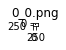

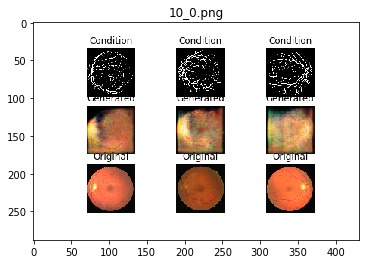

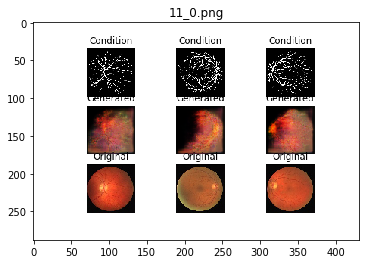

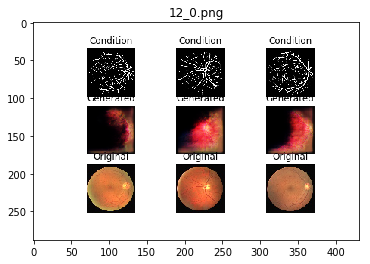

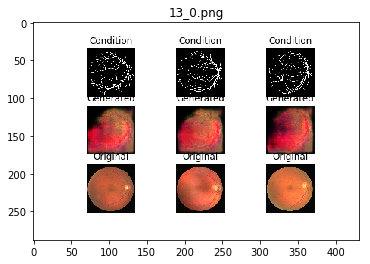

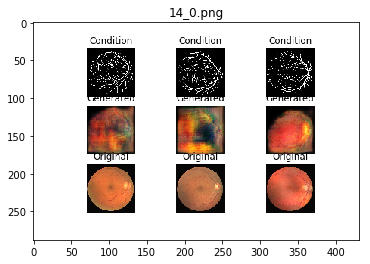

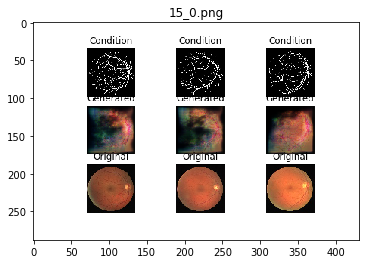

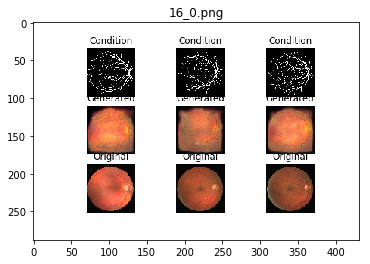

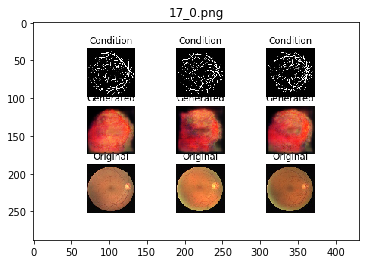

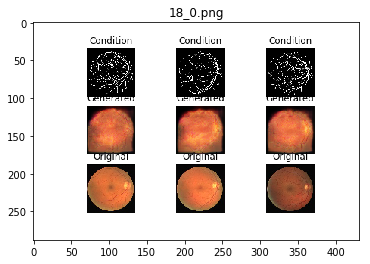

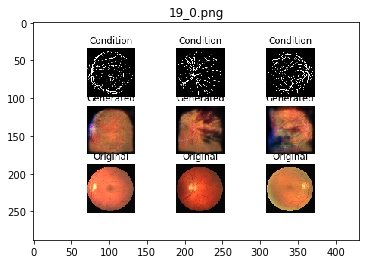

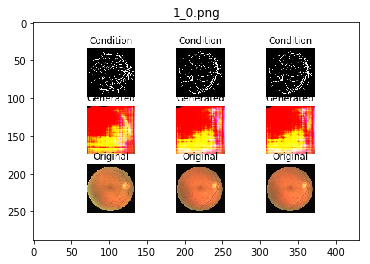

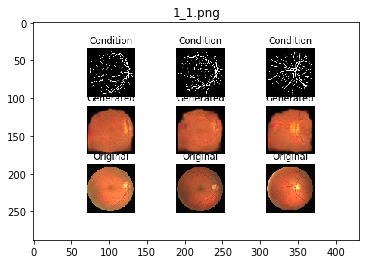

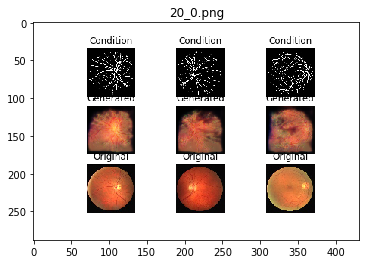

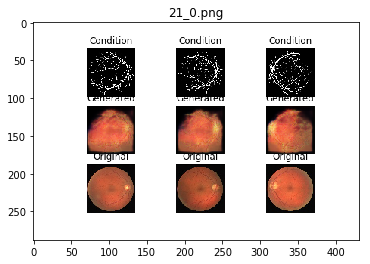

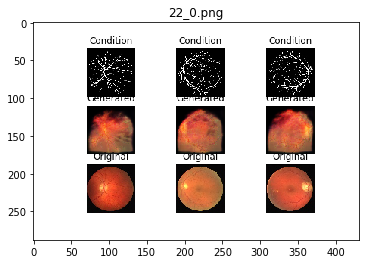

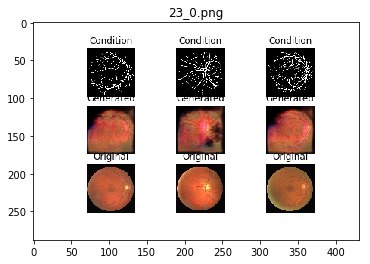

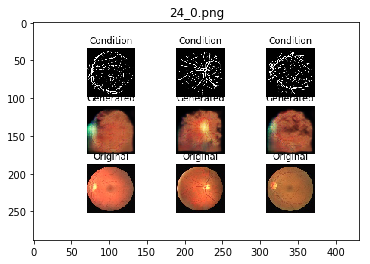

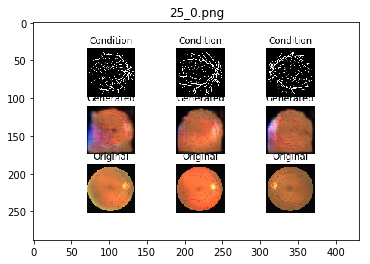

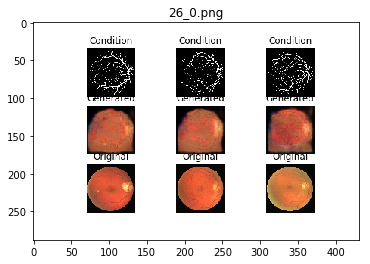

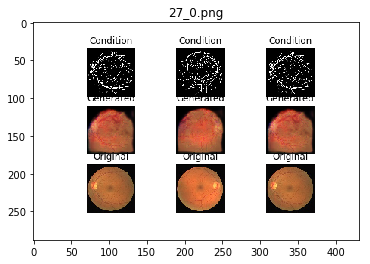

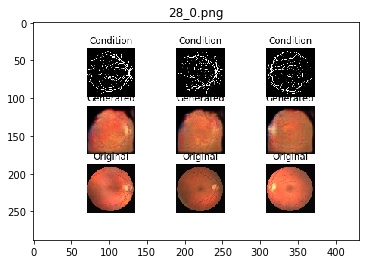

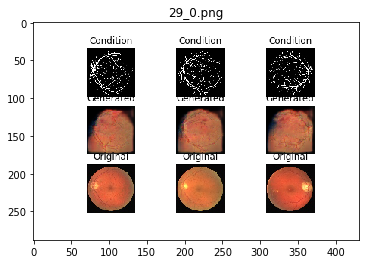

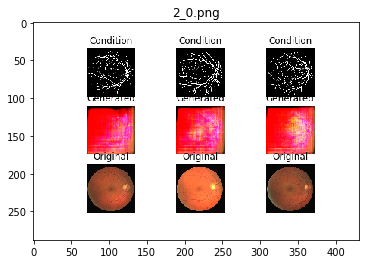

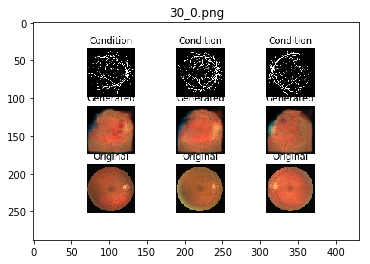

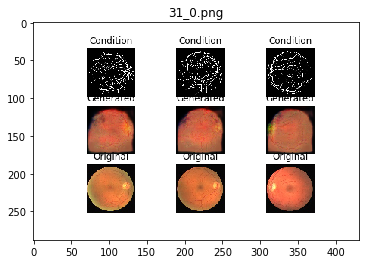

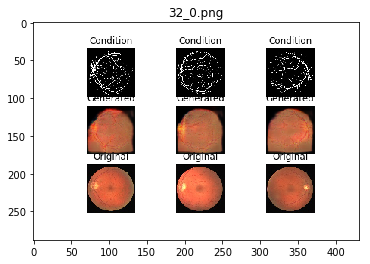

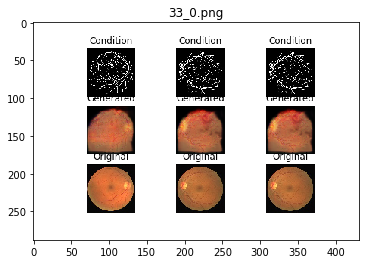

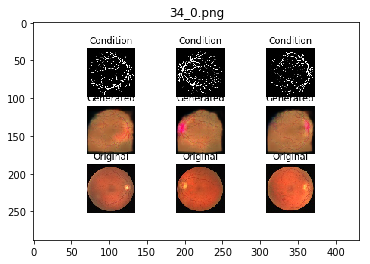

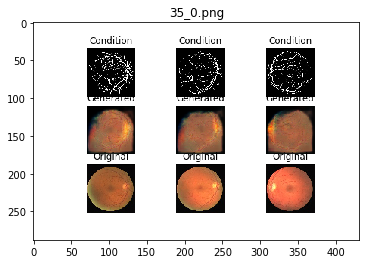

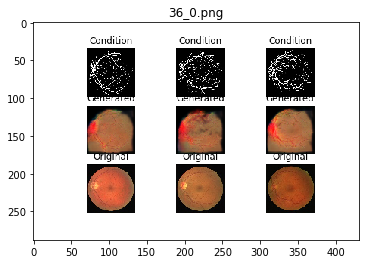

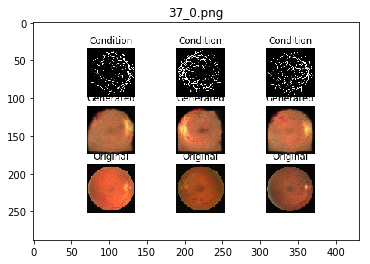

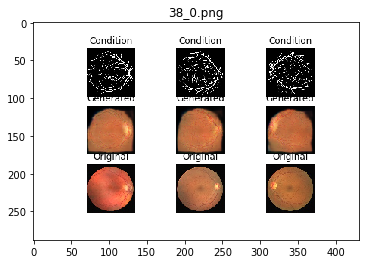

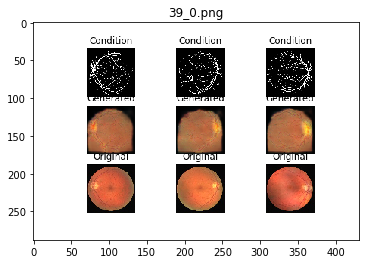

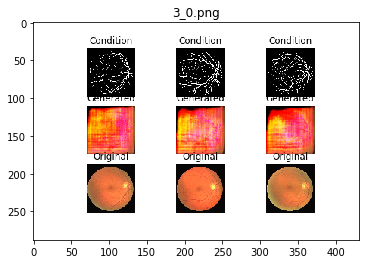

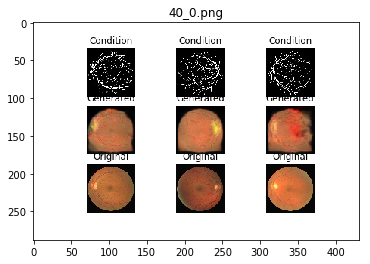

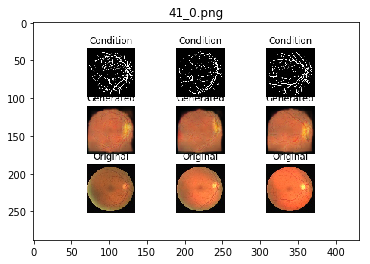

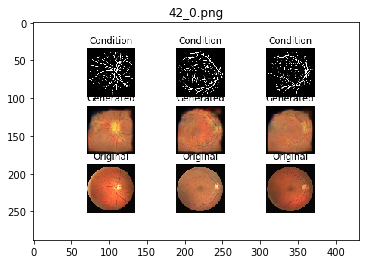

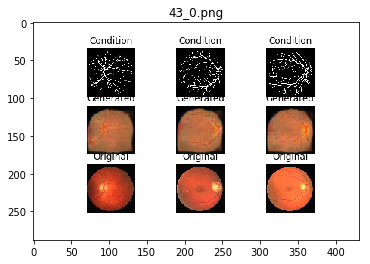

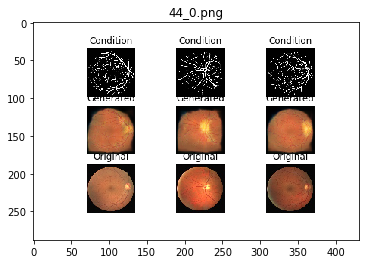

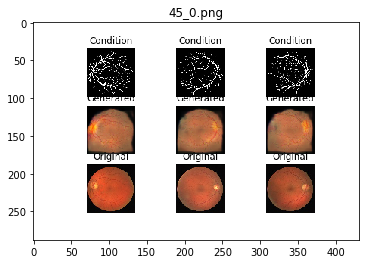

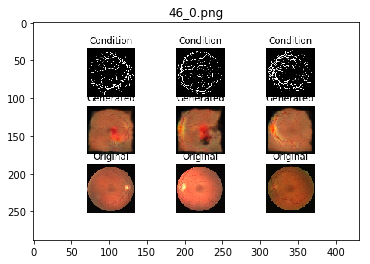

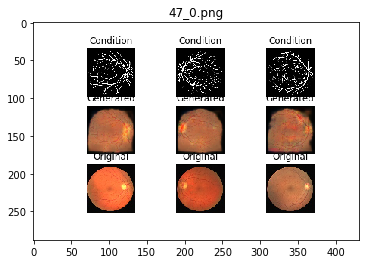

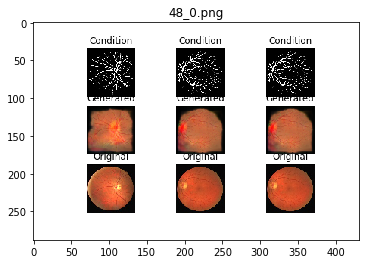

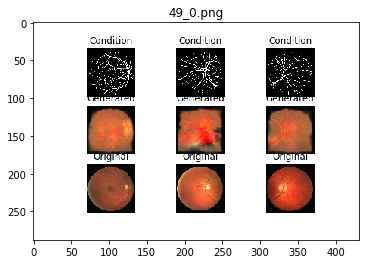

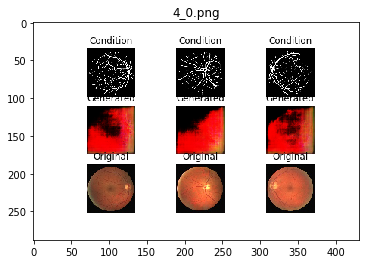

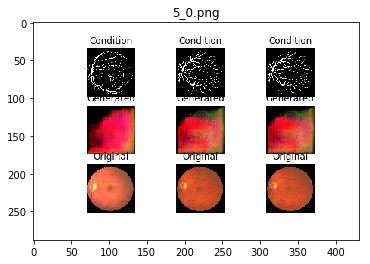

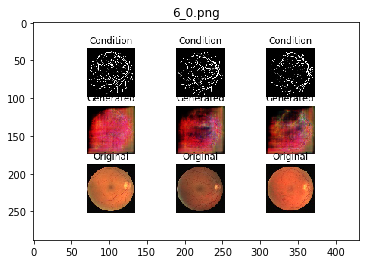

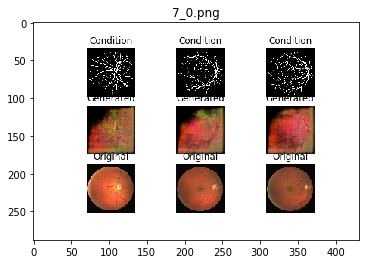

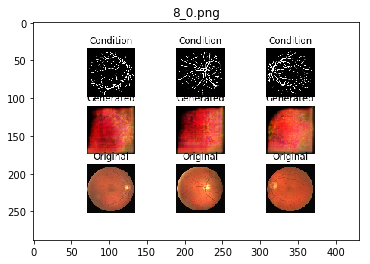

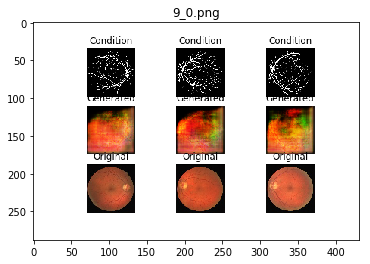

In [28]:
output='C:/Users/zecharpy/Desktop/pix2pix/images/RetinaData/'
results=os.listdir(output)
l=len(results)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(1,l+1):
    fig.add_subplot(1, l, i)
    im=plt.imread(output+results[i-1])
    plt.imshow(im)
    plt.title(results[i-1])
    plt.show()

